In [1]:
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from nilearn import plotting as ni_plt

import json, pickle
from tqdm import tqdm
import sys, os, pdb
import pandas as pd
from statannotations.Annotator import Annotator

from src.data_utils import ECoG_Data
import src.manifold_u as mu
import importlib
importlib.reload(mu)
import fig_utils as figu
importlib.reload(figu)

plt.style.use(['science', 'retro'])
sns.set_style("ticks")
plt.rcParams.update({"font.size": 10})

In [2]:
movement_colors, day_colors, participant_colors, exp_class_colors, exp_participant_colors, freq_colors = mu.get_all_colors()

In [3]:
filepath = '/home/zsteineh/research_projects/NaturalisticNeuralManifolds/experiment_params/'
file_name = 'exp_params_exp_pca.json'
try:
    json_filename = filepath + file_name
except IndexError:
    raise SystemExit(f"Usage: {sys.argv[0]} <json file of experiment parameters>")
with open(json_filename) as f:
    exp_params = json.load(f)
print(exp_params['comment'])

Param file for running PCA pipeline on experimental data


In [4]:
freq_bands = exp_params["freq_bands"]
class_dict = exp_params["class_dict"]
class_dict = {int(cur_key) - 1: val for cur_key, val in class_dict.items()}
class_dict = {key: val for key, val in class_dict.items()}
class_color = exp_params["class_color"]
class_color = {int(cur_key): val for cur_key, val in class_color.items()}

proj_mat_sp = exp_params["sp"] + exp_params["dataset"] + exp_params["experiment_folder"]

percent_threshold = 0.8
pats_ids_in = exp_params["pats_ids_in"]

cur_freq = 'Beta'
cur_freq_ind = 2
freq_red_dim = 7

In [5]:
mvmt_null_data_pa = np.load(exp_params['null_data_lp'] + 'TME_null_pas.npy', allow_pickle=True)
mvmt_null_data_pa = np.array(mvmt_null_data_pa)
print(mvmt_null_data_pa.shape)

(6, 8, 1000, 1, 1, 10, 15)


In [6]:
pat_null_data_pa = np.load(exp_params['cross_pat_null_pa_lp'] + 'TME_null_pas', allow_pickle=True)
pat_null_data_pa = np.array(pat_null_data_pa)
print(pat_null_data_pa.shape)

(3, 5, 1000, 1, 1, 28, 15)


In [7]:
cross_move_pas = pickle.load(open(proj_mat_sp + 'freq_cross_move_pas.pkl', 'rb'))
print(cross_move_pas.keys())

cross_move_nd_df = pd.read_csv(proj_mat_sp + 'freq_cross_move_nd_df.csv')
cross_move_nd_df

dict_keys(['LFO', 'Alpha', 'Beta', 'Low Gamma', 'Gamma', 'High Gamma'])


,Unnamed: 0,Frequency,Participant,Day,Movement Comparison,Neural Dissimilarity
0,0,LFO,E01,all,Thumb vs Index,0.125580
1,1,LFO,E01,all,Thumb vs Middle,0.094602
2,2,LFO,E01,all,Thumb vs Ring,0.127995
3,3,LFO,E01,all,Thumb vs Pinky,0.168099
4,4,LFO,E01,all,Index vs Middle,0.126452
...,...,...,...,...,...,...
300295,50045,High Gamma,Null,Null,Index vs Ring,0.819478
300296,50046,High Gamma,Null,Null,Index vs Pinky,0.810512
300297,50047,High Gamma,Null,Null,Middle vs Ring,0.828314
300298,50048,High Gamma,Null,Null,Middle vs Pinky,0.810416


In [8]:
cross_pat_pas = pickle.load(open(proj_mat_sp + 'freq_cross_pat_pas.pkl', 'rb'))
print(cross_pat_pas.keys())

cross_pat_nd_df = pd.read_csv(proj_mat_sp + 'freq_cross_pat_nd_df.csv')
cross_pat_nd_df

dict_keys(['LFO', 'Alpha', 'Beta', 'Low Gamma', 'Gamma', 'High Gamma'])


,Unnamed: 0,Frequency,Movement,Participant Comparison,First Participant Day,Second Participant Day,Electrode Overlap,Neural Dissimilarity
0,0,LFO,Thumb,E01 vs E02,all,all,0.562753,0.441023
1,1,LFO,Thumb,E01 vs E03,all,all,0.736842,0.442053
2,2,LFO,Thumb,E01 vs E04,all,all,0.573123,0.506292
3,3,LFO,Thumb,E01 vs E05,all,all,0.510823,0.537632
4,4,LFO,Thumb,E02 vs E03,all,all,0.884211,0.373387
...,...,...,...,...,...,...,...,...
50295,45,High Gamma,Pinky,E02 vs E04,all,all,0.806324,0.379968
50296,46,High Gamma,Pinky,E02 vs E05,all,all,0.826840,0.373320
50297,47,High Gamma,Pinky,E03 vs E04,all,all,0.660079,0.417805
50298,48,High Gamma,Pinky,E03 vs E05,all,all,0.597403,0.434713


#### Also get the naturalistic data for stats

In [9]:
filepath = '/home/zsteineh/research_projects/NaturalisticNeuralManifolds/experiment_params/'
file_name = 'exp_params_nat_pca.json'
try:
    json_filename = filepath + file_name
except IndexError:
    raise SystemExit(f"Usage: {sys.argv[0]} <json file of experiment parameters>")
with open(json_filename) as f:
    exp_params = json.load(f)
print(exp_params['comment'])

proj_mat_sp = exp_params["sp"] + exp_params["dataset"] + exp_params["experiment_folder"]

nat_cross_move_nd_df = pd.read_csv(proj_mat_sp + 'freq_cross_move_nd_df.csv')
print(nat_cross_move_nd_df)
nat_cross_pat_nd_df = pd.read_csv(proj_mat_sp + 'freq_cross_pat_nd_df.csv')
print(nat_cross_pat_nd_df)

Param file for running PCA pipeline on naturalistic data
        Unnamed: 0   Frequency Participant   Day Movement Comparison  \
0                0         LFO         P01     3        left vs down   
1                1         LFO         P01     3       left vs right   
2                2         LFO         P01     3          left vs up   
3                3         LFO         P01     3       down vs right   
4                4         LFO         P01     3          down vs up   
...            ...         ...         ...   ...                 ...   
434155       72355  High Gamma        Null  Null       left vs right   
434156       72356  High Gamma        Null  Null          left vs up   
434157       72357  High Gamma        Null  Null       down vs right   
434158       72358  High Gamma        Null  Null          down vs up   
434159       72359  High Gamma        Null  Null         right vs up   

        Neural Dissimilarity  
0                   0.108478  
1               

In [10]:
q1_sigf_val = mu.calc_sumed_significance(cross_move_nd_df)
print(q1_sigf_val)

# pull the current freq data out
cur_freq_only = cross_move_nd_df.loc[
    (cross_move_nd_df["Frequency"] == cur_freq)
    | (cross_move_nd_df["Frequency"] == "Null")
]

0.7141559551760432


In [11]:
q4_sigf_val = mu.calc_sumed_significance(cross_pat_nd_df, null_col='Movement')
print(q4_sigf_val)

q4_cur_freq_only = cross_pat_nd_df.loc[
    (cross_pat_nd_df["Frequency"] == cur_freq)
    | (cross_pat_nd_df["Frequency"] == "Null")
]

0.7179937943879552


In [12]:
# get just the cur freq for nat dataframes
nat_cross_move_nd_df = nat_cross_move_nd_df.loc[(nat_cross_move_nd_df['Frequency'] == cur_freq) & (nat_cross_move_nd_df['Participant'] != "Null")]
nat_cross_pat_nd_df = nat_cross_pat_nd_df.loc[nat_cross_pat_nd_df['Frequency'] == cur_freq]
print(nat_cross_move_nd_df.head())
print(nat_cross_pat_nd_df.head())
nat_cross_move_nd_df['Experiment Type'] = 'Nat\n Cross-Mvmt'
nat_cross_pat_nd_df['Experiment Type'] = 'Nat\n Cross-Pat'

# combine the nat data with the experimental dataframes
exp_cross_mvmt_df = cur_freq_only[(cur_freq_only['Frequency'] == cur_freq) & (cur_freq_only['Participant'] != "Null")]
exp_cross_mvmt_df['Experiment Type'] = 'Exp\n Cross-Mvmt'
exp_cross_pat_df = q4_cur_freq_only[q4_cur_freq_only['Frequency'] == cur_freq]
exp_cross_pat_df['Experiment Type'] = 'Exp\n Cross-Pat'

all_df = pd.concat([nat_cross_move_nd_df, nat_cross_pat_nd_df, exp_cross_mvmt_df, exp_cross_pat_df])
all_df

        Unnamed: 0 Frequency Participant Day Movement Comparison  \
144720           0      Beta         P01   3        left vs down   
144721           1      Beta         P01   3       left vs right   
144722           2      Beta         P01   3          left vs up   
144723           3      Beta         P01   3       down vs right   
144724           4      Beta         P01   3          down vs up   

        Neural Dissimilarity  
144720              0.117511  
144721                   NaN  
144722                   NaN  
144723                   NaN  
144724                   NaN  
        Unnamed: 0 Frequency Movement Participant Comparison  \
277200           0      Beta     left             P01 vs P02   
277201           1      Beta     left             P01 vs P02   
277202           2      Beta     left             P01 vs P02   
277203           3      Beta     left             P01 vs P02   
277204           4      Beta     left             P01 vs P02   

       First Partici

/home/zsteineh/anaconda3/envs/ECoGDL_venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/zsteineh/anaconda3/envs/ECoGDL_venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,Unnamed: 0,Frequency,Participant,Day,Movement Comparison,Neural Dissimilarity,Experiment Type,Movement,Participant Comparison,First Participant Day,Second Participant Day,Electrode Overlap
144720,0,Beta,P01,3,left vs down,0.117511,Nat\n Cross-Mvmt,NaN,NaN,NaN,NaN,NaN
144721,1,Beta,P01,3,left vs right,NaN,Nat\n Cross-Mvmt,NaN,NaN,NaN,NaN,NaN
144722,2,Beta,P01,3,left vs up,NaN,Nat\n Cross-Mvmt,NaN,NaN,NaN,NaN,NaN
144723,3,Beta,P01,3,down vs right,NaN,Nat\n Cross-Mvmt,NaN,NaN,NaN,NaN,NaN
144724,4,Beta,P01,3,down vs up,NaN,Nat\n Cross-Mvmt,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
50145,45,Beta,NaN,NaN,NaN,0.324892,Exp\n Cross-Pat,Pinky,E02 vs E04,all,all,0.806324
50146,46,Beta,NaN,NaN,NaN,0.278574,Exp\n Cross-Pat,Pinky,E02 vs E05,all,all,0.826840
50147,47,Beta,NaN,NaN,NaN,0.456516,Exp\n Cross-Pat,Pinky,E03 vs E04,all,all,0.660079
50148,48,Beta,NaN,NaN,NaN,0.400772,Exp\n Cross-Pat,Pinky,E03 vs E05,all,all,0.597403


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Nat
 Cross-Mvmt vs. Exp
 Cross-Mvmt: Welch's t-test independent samples, P_val:1.270e-04 t=4.016e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Nat
 Cross-Pat vs. Exp
 Cross-Pat: Welch's t-test independent samples, P_val:1.982e-02 t=-2.406e+00


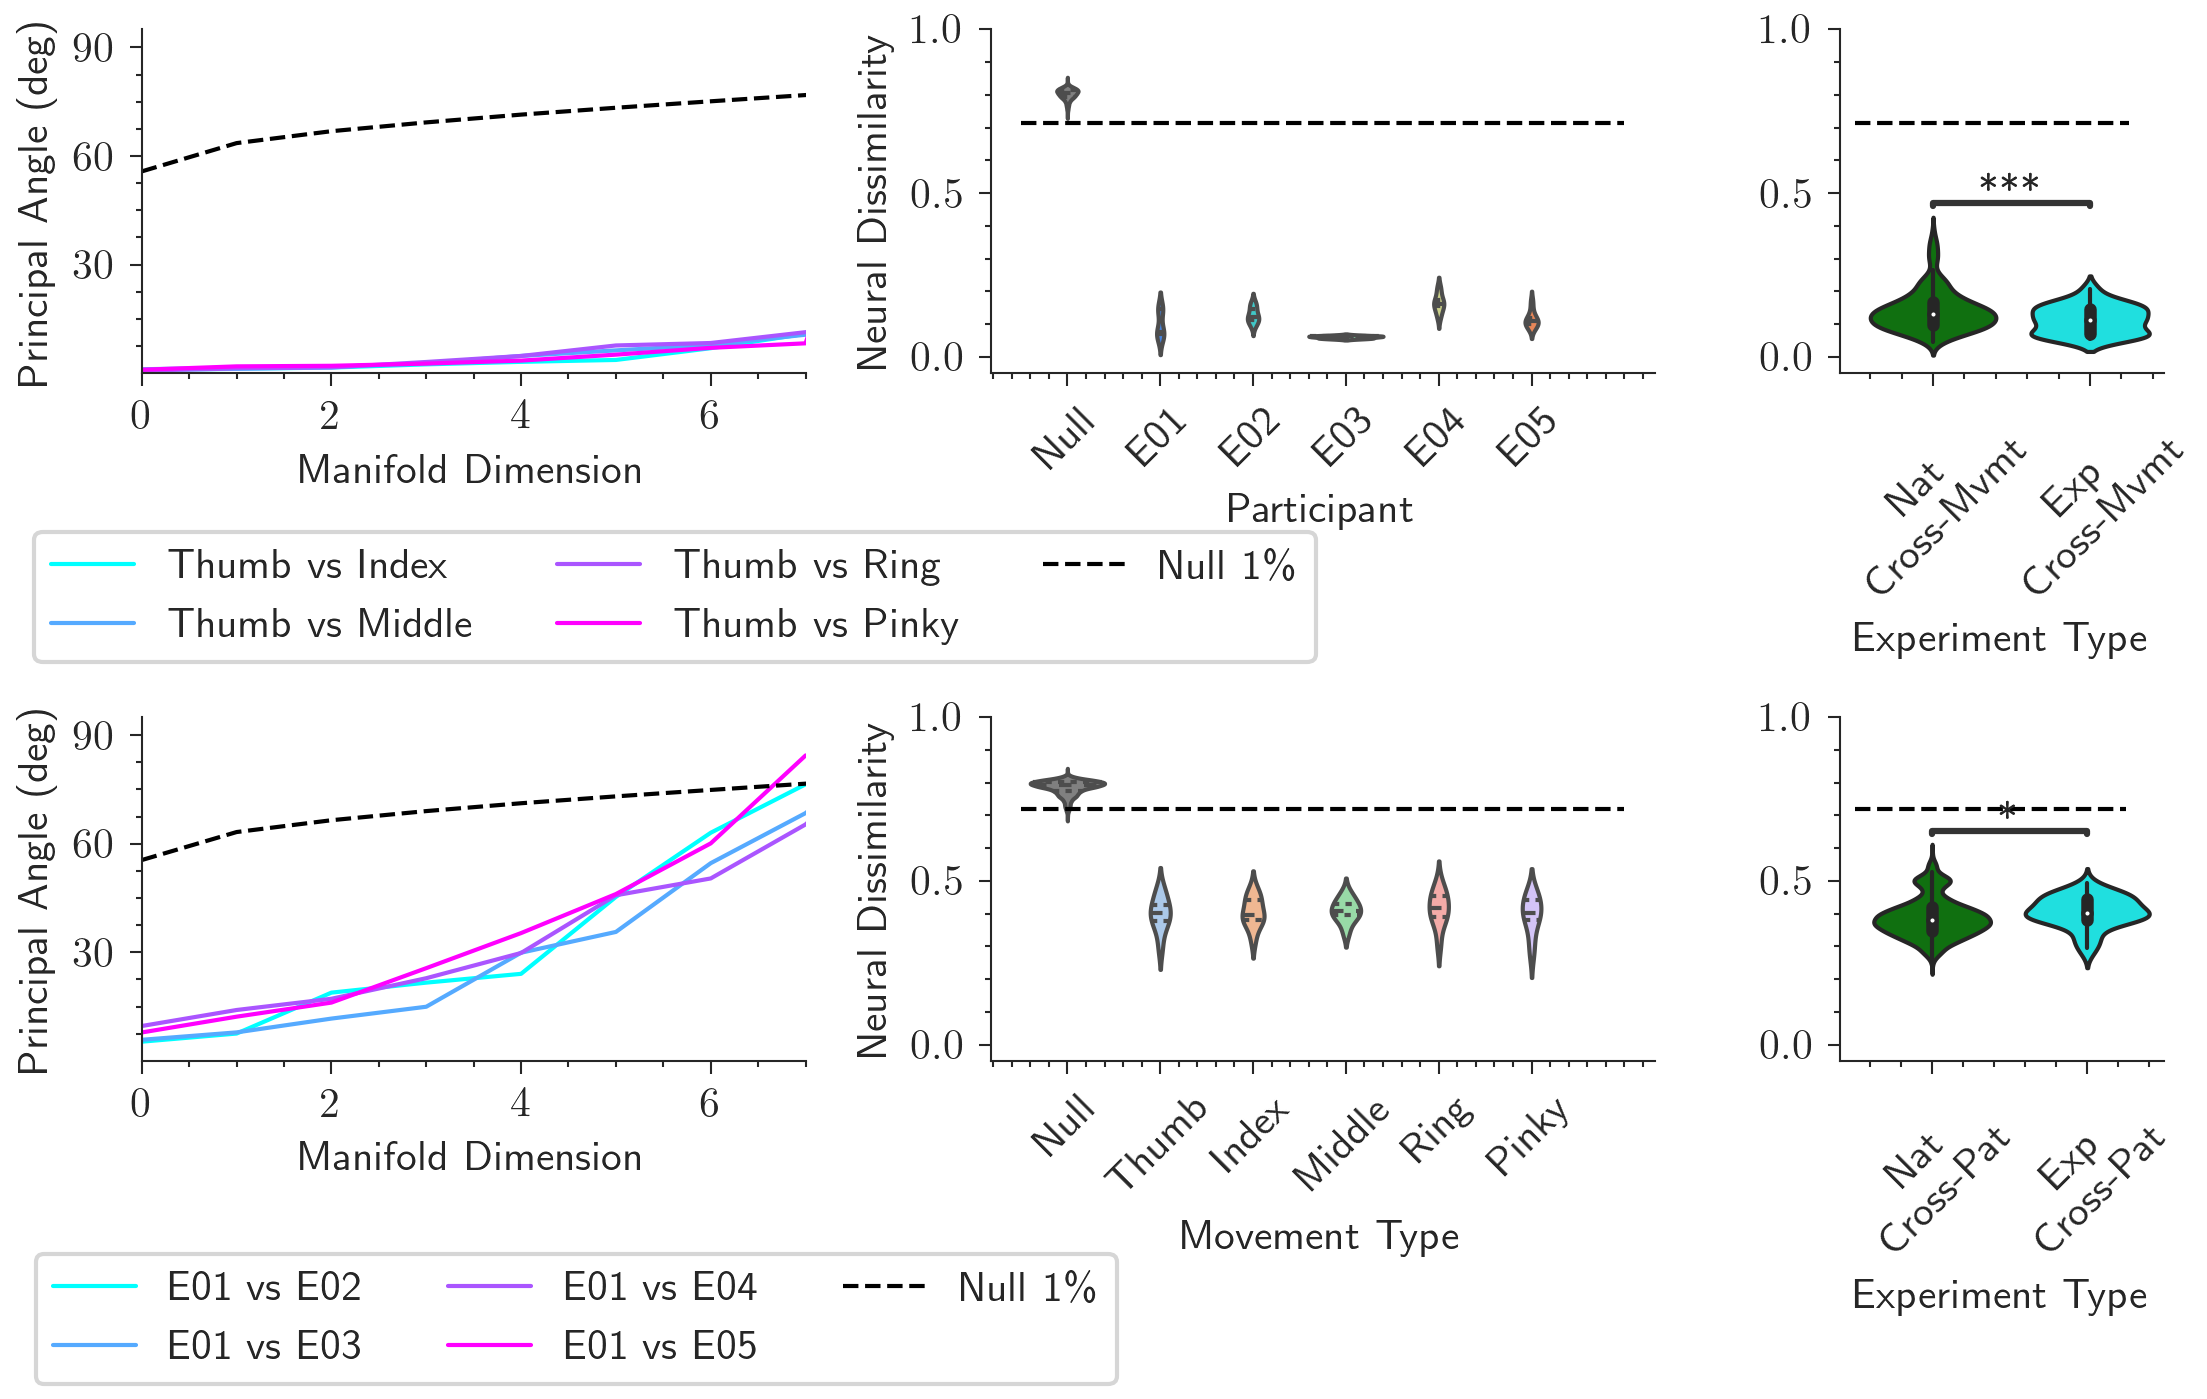

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(7.5, 4), dpi = 300)
plt.tight_layout()
plt.rcParams.update({"font.size": 10})
# plt.subplots_adjust(hspace=0.45)

axes = GridSpec(2, 12, figure=fig)
axes.update(wspace=0.1, hspace=1.0)

comps_to_plot = np.arange(0, 4)
ax0 = plt.subplot(axes[0,0:4])
null_pa = mvmt_null_data_pa[cur_freq_ind,0,...]
signf_null_pas = np.squeeze(np.percentile(null_pa, 1, axis=0).mean(axis=2))
figu.plot_PAs(ax0, 
            class_dict, 
            comps_to_plot, 
            np.expand_dims(cross_move_pas[cur_freq], axis=0), 
            mvmt_null_data_pa,
            freq_red_dim,
            null_sig_pas = signf_null_pas,
            )
ax0.legend(frameon=True, bbox_to_anchor=(1.8, -0.4), ncol=3)
# axes[0,0].set_title("A) Cross-Movement Principal Angles")

order = ["Null"]
order.extend(pats_ids_in)
ax1 = plt.subplot(axes[0,5:9])
figu.plot_neural_dissimilarity(ax1, 
                          cur_freq_only, 
                          q1_sigf_val, 
                          order, 
                          exp_participant_colors)
ax1.set_yticks([0, 0.5, 1])
# axes[0,1].set_title("B) Cross-Movement Neural Dissimilarity")

# significiance plot
order = ['Nat\n Cross-Mvmt', 
         'Exp\n Cross-Mvmt']
colors = {'Nat\n Cross-Mvmt': 'green',
          'Exp\n Cross-Mvmt': 'cyan',
          'Nat\n Cross-Pat': 'green',
          'Exp\n Cross-Pat': 'cyan'}
x = 'Experiment Type'
y = 'Neural Dissimilarity'
ax2 = plt.subplot(axes[0,10:])
sns.violinplot(data=all_df, x=x, y=y, order=order, palette=colors, ax=ax2)
pairs=[('Nat\n Cross-Mvmt', 'Exp\n Cross-Mvmt')]
annotator = Annotator(ax2, pairs, data=all_df, x=x, y=y, order=order)
annotator.configure(test='t-test_welch', text_format='star', loc='outside')
annotator.apply_and_annotate()

ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.set_ylabel("")
ax2.set_yticks([0, 0.5, 1])
ax2.set_xticklabels(labels=order, rotation=45)
ax2.set_ylim([-0.05, 1])
ax2.hlines(q1_sigf_val, -0.5, 1.25, linestyles="dashed", color="black")

# second row
comps_to_plot = np.arange(0, 4)
ax3 = plt.subplot(axes[1,0:4])
null_pa = pat_null_data_pa[cur_freq_ind,0,...]
signf_null_pas = np.squeeze(np.percentile(null_pa, 1, axis=0).mean(axis=2))
figu.plot_PAs(ax3, 
            pats_ids_in, 
            comps_to_plot, 
            np.expand_dims(cross_pat_pas[cur_freq], axis=(0, 2)), 
            pat_null_data_pa,
            red_dim = freq_red_dim,
            null_sig_pas = signf_null_pas
            )
ax3.legend(frameon=True, bbox_to_anchor=(1.5, -0.5), ncol=3)
# axes[1,0].set_title("C) Cross-Participant Principal Angles")

order = ["Null"]
order.extend(class_dict.values())
ax4 = plt.subplot(axes[1,5:9])
figu.plot_neural_dissimilarity(ax4, 
                          q4_cur_freq_only, 
                          q4_sigf_val, 
                          order, 
                          exp_class_colors, 
                          x="Movement")
ax4.set_yticks([0, 0.5, 1])
ax4.set_xlabel("Movement Type")
# axes[1,1].set_title("D) Cross-Participant Neural Dissimilarity")

# significiance plot
order = ['Nat\n Cross-Pat', 
         'Exp\n Cross-Pat']
x = 'Experiment Type'
y = 'Neural Dissimilarity'
ax5 = plt.subplot(axes[1,10:])
sns.violinplot(data=all_df, x=x, y=y, order=order, palette=colors, ax=ax5)
pairs=[('Nat\n Cross-Pat', 'Exp\n Cross-Pat')]
annotator = Annotator(ax5, pairs, data=all_df, x=x, y=y, order=order)
annotator.configure(test='t-test_welch', text_format='star', loc='outside')
annotator.apply_and_annotate()

ax5.spines["top"].set_visible(False)
ax5.spines["right"].set_visible(False)
ax5.set_xticklabels(labels=order, rotation=45)
ax5.set_ylabel("")
ax5.set_yticks([0, 0.5, 1])
ax5.set_ylim([-0.05, 1])
ax5.hlines(q4_sigf_val, -0.5, 1.25, linestyles="dashed", color="black")

plt.savefig("/home/zsteineh/research_projects/NaturalisticNeuralManifolds/figures/saved_figures/exp_nm_results.svg", format="svg", bbox_inches="tight")
plt.show()

### Get reporting numbers

In [14]:
print("CROSS MOVEMENT")
avg_pas = np.round(np.nanmean(cross_move_pas['Beta'], axis=(0, 1, 2)), 3)
std_pas = np.round(np.nanstd(cross_move_pas['Beta'], axis=(0, 1, 2)), 3)
print("First PA Average: ", avg_pas[0])
print("First PA STD: ", std_pas[0])
print("Last PA Average: ", avg_pas[-1])
print("Last PA STD: ", std_pas[-1])

CROSS MOVEMENT
First PA Average:  1.393
First PA STD:  0.696
Last PA Average:  45.644
Last PA STD:  25.875


In [15]:
print("CROSS PARTICIPANT")
avg_pas = np.round(np.nanmean(cross_pat_pas['Beta'], axis=(0, 1)), 3)
std_pas = np.round(np.nanstd(cross_pat_pas['Beta'], axis=(0, 1)), 3)
print("First PA Average: ", avg_pas[0])
print("First PA STD: ", std_pas[0])
print("Last PA Average: ", avg_pas[-1])
print("Last PA STD: ", std_pas[-1])

CROSS PARTICIPANT
First PA Average:  6.886
First PA STD:  1.562
Last PA Average:  85.891
Last PA STD:  3.202


In [16]:
avg_pat_nd = np.round(cur_freq_only[cur_freq_only["Participant"] != "Null"]['Neural Dissimilarity'].mean(), 3)
std_pat_nd = np.round(cur_freq_only[cur_freq_only["Participant"] != "Null"]['Neural Dissimilarity'].std(), 3)
print("Average Cross Movement Neural Dissimilarity: ", avg_pat_nd)
print("STD Cross Movement Neural Dissimilarity: ", std_pat_nd)

Average Cross Movement Neural Dissimilarity:  0.114
STD Cross Movement Neural Dissimilarity:  0.043


In [17]:
print("Null 1% Significance:", np.round(q1_sigf_val, 3))

Null 1% Significance: 0.714


In [18]:
avg_pat_nd = np.round(q4_cur_freq_only[q4_cur_freq_only["Frequency"] != "Null"]['Neural Dissimilarity'].mean(), 3)
std_pat_nd = np.round(q4_cur_freq_only[q4_cur_freq_only["Frequency"] != "Null"]['Neural Dissimilarity'].std(), 3)
print("Average Cross Pat Neural Dissimilarity: ", avg_pat_nd)
print("STD Cross Pat Neural Dissimilarity: ", std_pat_nd)

Average Cross Pat Neural Dissimilarity:  0.405
STD Cross Pat Neural Dissimilarity:  0.048


In [19]:
print("Average electrode overlap:", np.round(q4_cur_freq_only[q4_cur_freq_only["Frequency"] != "Null"]['Electrode Overlap'].mean(), 3))
print("STD electrode overlap:", np.round(q4_cur_freq_only[q4_cur_freq_only["Frequency"] != "Null"]['Electrode Overlap'].std(), 3))

Average electrode overlap: 0.705
STD electrode overlap: 0.137


In [20]:
print("Null 1% Significance:", np.round(q4_sigf_val, 3))

Null 1% Significance: 0.718
